In [30]:
import numpy as np
from scipy.integrate import tplquad,dblquad
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
from IPython.display import Image

k = 8.987551E9  #coulomb's constant

In [31]:
#NOTE THIS IS FORCE ELEMENT. YOU HAVE TO INTEGRATE THIS THROUGH THE ENTIRE SURFACE TO GET OVERALL FORCE.
#outputs force element in direction i, given coulomb's constant k, test charge position p, and density rho for a sphere. 

def Force_element_sphere(r,theta,phi):
    r_vector = np.array([r*np.sin(phi)*np.cos(theta),r*np.sin(phi)*np.sin(theta),r*np.cos(phi)])
    distance= p-r_vector
    dV = np.linalg.norm(r_vector)**2*np.sin(phi)
    dq = dV*rho
    dF = dq*k*distance/(np.linalg.norm(distance)**3)
    return dF[i]

#outputs force element in direction i (i  will be defined later) , given coulomb's constant k, test charge position p, and 
#density rho for a DISK. 

def Force_element_disk(r,theta):
    r_vector = np.array([r*np.cos(theta),r*np.sin(theta),0])
    distance= p-r_vector
    dS = np.linalg.norm(r_vector)
    dq = dS*rho
    dF = dq*k*distance/(np.linalg.norm(distance)**3)
    return dF[i]

In [32]:
class surface: 
    "EM surface takes arguments density, shape, and linear dim. Linear dim can be radius, width, etc. make_plot returns an array of data that defines the physical surface"
    def __init__(self, density,shape,linear_dim):
        self.rho = density
        self.s = shape
        self.dim= linear_dim
    def make_plot(self):
        u = np.linspace(0, 2 * np.pi, 40)
        v = np.linspace(0, np.pi, 40)
        if self.s=='sphere':
            x = self.dim*np.outer(np.cos(u), np.sin(v)) #data arrays that define a sphere's surface
            y = self.dim*np.outer(np.sin(u), np.sin(v))
            z = self.dim*np.outer(np.ones(np.size(u)), np.cos(v))
        if self.s=='disk':
            x = self.dim*np.outer(np.cos(u), np.sin(v)) #data arrays that define a disk's surface
            y = self.dim*np.outer(np.sin(u), np.sin(v))
            z = self.dim*np.outer(np.ones(np.size(u))*0, np.cos(v)*0) 
            #add another shape's surface points here
        return [x,y,z]

In [33]:
class test_charge:
    "test charge takes attribute position, which should be a 3d array"
    def __init__(self,position,charge):
        self.p = np.array(position)
        self.q_1=charge
    def force(self,surface):
        F = list()
        global p,rho,i,q_1  #making sure these values don't get lost in the class by definining them as global.
        rho = surface.rho
        p = self.p
        q_1 = self.q_1
        if surface.s == 'sphere':
            for j in range(3): #cycling through the three dimensions of the force (because scipy doesn't do vector integration)
                i=j
                #tplquad returns the triple integral of the force
                F.append(tplquad(Force_element_sphere,0,np.pi,lambda phi: 0, lambda phi: 2*np.pi,
                                 lambda phi,theta: 0, lambda phi, theta: surface.dim,epsabs=100000)[0]) #epsabs is high because we want a fast integration
        elif surface.s=='disk':
            for j in range(3):
                i=j
                #tplquad returns the triple integral of the force
                F.append(dblquad(Force_element_disk,0,2*np.pi,lambda theta: 0, lambda theta: surface.dim,epsabs=100000)[0])
        return F



In [34]:
#defining our initial surface and test charge

p=[2.,2.,2.]
sphere=surface(density= 1.,shape = 'sphere', linear_dim= 1.)
test=test_charge(p,1)
surf=sphere.make_plot()
F= test.force(sphere)

#creating our initial surface, point, and force(line) plot

trace1 = go.Surface(
            colorscale = [[0,'rgb('+str(115)+',7,122)'],[1,'rgb('+str(80)+',80,230)']],
            showscale=False,
            z = surf[2],
            x= surf[0],
            y = surf[1])
trace2 = go.Scatter3d(
            x = [p[0],p[0]+F[0]*(0.5*10**(-9))],
            y= [p[1],p[1]+F[1]*(0.5*10**(-9))],
            z=[p[2],p[2]+F[2]*(0.5*10**(-9))],
            marker = dict(
                    size=2,
                    color= 'rgb(21,117,22)',
                    symbol= 'diamond'
                    ),
            line=dict(
                    width=5,
                    color='rgb(21,117,22)',
                    ))
trace3 = go.Scatter3d(
            x = [p[0]],
            y= [p[1]],
            z=[p[2]],
            marker = dict(
                    size=5,
                    color= 'rgb(214,11,8)'
                    )
            )
data=[trace1,trace2,trace3]

In [35]:
layout = dict(
                width = 700,height=700,
                autosize=True,
                scene = dict(
                xaxis = dict(range=[-8, 8], autorange=False, zeroline=False),
                yaxis= dict(range=[-8, 8], autorange=False, zeroline=False),
                zaxis=dict(range=[-8, 8], autorange=False, zeroline=False),
                aspectmode = 'cube',
                camera = dict(center=dict(x=0,y=0,z=0),eye=dict(x=1,y=-1,z=0.1))
                ),
                margin=dict(),
                showlegend = False
                )

#creating slider frames, that cycle through x position of test charge
slider_range=6
steps=[]
for i in range(0,slider_range,1):
    p=[i,2.,2.]
    test=test_charge(p,1)
    F= test.force(sphere)
    step = dict(
        method='update',
        args=[{'x':[surf[0],[p[0],p[0]+F[0]*(0.5*10**(-9))],[p[0]]],
                'y':[surf[1],[p[1],p[1]+F[1]*(0.5*10**(-9))],[p[1]]],
                'z':[surf[2],[p[2],p[2]+F[2]*(0.5*10**(-9))],[p[2]]]}]
    )
    steps.append(step)
    
sliders= [dict(
    active=2,
    currentvalue={'prefix':'x position'},
    pad={'t':slider_range},
    steps=steps
)]
layout['sliders'] = sliders

In [36]:
fig=go.Figure(data=data,layout=layout)
iplot(fig)

<p>
  
</p>
<font size="26">Electric Field On Point Charge</font>

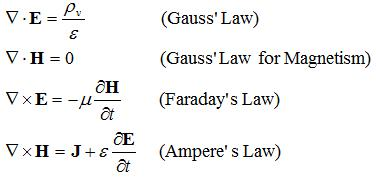

In [37]:
Image("http://www.antenna-theory.com/definitions/maxwellseq.jpg")